In [13]:
# Pytorch packages
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn as nn
import torch_geometric.nn as pyg_nn
from torch_geometric.utils import to_networkx
from torch_geometric.utils import add_self_loops, degree

# Other packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import meshio

In [14]:
# CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [23]:
def create_data_obj(mesh_file, data_file="", include_data=True):

    mesh = meshio.read(mesh_file)
    node_pos = torch.tensor(mesh.points[:, :2], dtype=torch.float, device=device)
    mesh_size = mesh.points.shape[0]

    def get_data(file):
        df = pd.read_csv(file, sep=',', skipinitialspace=True)
        df = df.iloc[:mesh_size]

        u = torch.tensor(df["Deformation X"].values, dtype=torch.float).view(-1, 1)
        v = torch.tensor(df["Deformation Y"].values, dtype=torch.float).view(-1, 1)
        sxx = torch.tensor(df["Stress X"].values, dtype=torch.float).view(-1, 1)
        syy = torch.tensor(df["Stress Y"].values, dtype=torch.float).view(-1, 1)
        sxy = torch.tensor(df["Shear"].values, dtype=torch.float).view(-1, 1)

        target_data = torch.cat([u, v, sxx, syy, sxy], dim=1).to(device)
        return target_data

    edges = []
    for cell in mesh.cells:
        if cell.type == "triangle":
            for element in cell.data:
                edges.append([element[0], element[1]])
                edges.append([element[1], element[0]])

                edges.append([element[1], element[2]])
                edges.append([element[2], element[1]])

                edges.append([element[2], element[0]])
                edges.append([element[0], element[2]])

    edges = torch.tensor(edges, dtype=torch.long, device=device).t().contiguous()
    
    source_nodes = edges[0]
    target_nodes = edges[1]

    source_pos = node_pos[source_nodes]
    target_pos = node_pos[target_nodes]
    edge_length = torch.norm(source_pos - target_pos, dim=1, keepdim=True)
    
    if include_data:
        target_data = get_data(data_file)
        graph = Data(x=node_pos, target=target_data, edge_index=edges, edge_attr=edge_length).to(device)
    else:
        graph = Data(x=node_pos, edge_index=edges, edge_attr=edge_length).to(device)

    print(graph)

    return graph


In [48]:
class MPNN(pyg_nn.MessagePassing):
    def __init__(self, latent_size, in_edge_size, in_node_size):
        super(MPNN, self).__init__(aggr="add")
        
        self.latent_size = latent_size

        self.edge_net = nn.Sequential(
            nn.Linear(in_edge_size, latent_size),
            nn.ReLU(),
            nn.Linear(latent_size, latent_size),
            nn.ReLU(),
            nn.LayerNorm(latent_size)
        )

        self.node_net = nn.Sequential(
            nn.Linear(in_node_size, latent_size),
            nn.ReLU(),
            nn.Linear(latent_size, latent_size),
            nn.ReLU(),
            nn.LayerNorm(latent_size)
        )

    def forward(self, x, edge_index, edge_attr):
        aggr_messages = self.propagate(edge_index, x=x, edge_attr=edge_attr)

        updated_nodes = self.node_net(torch.cat([x, aggr_messages], dim=1))

        row, col = edge_index
        updated_edges = self.edge_net(torch.cat([x[row], x[col], edge_attr], dim=1))

        return updated_nodes, updated_edges
    
    def message(self, x_i, x_j, edge_attr):
        msg = torch.cat([x_i, x_j, edge_attr], dim=1)
        return self.edge_net(msg)
    
    def update(self, aggr_out):
        return aggr_out
    

class EncodeProcessDecode(nn.Module):
    def __init__(self, node_feat_size, edge_feat_size, latent_size, output_size, num_layers):
        super(EncodeProcessDecode, self).__init__()

        self.latent_size = latent_size

        # Node encoder: maps raw node features to latent space.
        self.node_encoder = nn.Sequential(
            nn.Linear(node_feat_size, latent_size),
            nn.ReLU(),
            nn.Linear(latent_size, latent_size),
            nn.ReLU(),
            nn.LayerNorm(latent_size)
        )
        # Edge encoder: maps raw edge features to latent space.
        self.edge_encoder = nn.Sequential(
            nn.Linear(edge_feat_size, latent_size),
            nn.ReLU(),
            nn.Linear(latent_size, latent_size),
            nn.ReLU(),
            nn.LayerNorm(latent_size)
        )
        
        # Processor: stack of message-passing blocks.
        self.layers = nn.ModuleList([
            MPNN(latent_size, latent_size * 3, latent_size * 2)
            for _ in range(num_layers)
        ])
        
        # Decoder: maps latent node features to final predictions (5 variables per node).
        self.node_decoder = nn.Sequential(
            nn.Linear(latent_size, latent_size),
            nn.ReLU(),
            nn.Linear(latent_size, output_size)
        )

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        x = self.node_encoder(x)
        edge_attr = self.edge_encoder(edge_attr)

        for layer in self.layers:
            x_res, edge_res = x, edge_attr
            x, edge_attr = layer(x, edge_index, edge_attr)
            x = x + x_res
            edge_attr = edge_attr + edge_res
        
        out = self.node_decoder(x)
        return out


In [49]:
class Solver():
    def __init__(self, loader):
        self.loader = loader

        self.E = 7e10
        self.sigma_0 = 50e6
        self.U = self.sigma_0 / self.E
        self.nu = 0.33

        self.node_feat_size = 2
        self.edge_feat_size = 1
        self.latent_size = 128
        self.output_size = 5
        self.num_layers = 4

        self.adam_lr = 0.005

        self.model = EncodeProcessDecode(self.node_feat_size, self.edge_feat_size, self.latent_size, self.output_size, self.num_layers).to(device)
        self.optimizer_adam = torch.optim.Adam(self.model.parameters(), lr=self.adam_lr)

        self.loss_fn = nn.MSELoss()

    def model_value(self, data):
        out = self.model(data)
        u = out[:, 0:1]
        v = out[:, 1:2]
        sxx = out[:, 2:3]
        syy = out[:, 3:4]
        sxy = out[:, 4:5]
        return u, v, sxx, syy, sxy
    
    def data_loss(self, data):
        target = data.target

        ut = target[:, 0:1] / self.U
        vt = target[:, 1:2] / self.U
        sxxt = target[:, 2:3] / self.sigma_0
        syyt = target[:, 3:4] / self.sigma_0
        sxyt = target[:, 4:5] / self.sigma_0

        u, v, sxx, syy, sxy = self.model_value(data)
        out = torch.cat([u, v, sxx, syy, sxy], dim=1)
        target = torch.cat([ut, vt, sxxt, syyt, sxyt], dim=1)
        d = self.loss_fn(out, target)
        return d
    
    def train(self, epochs=1000):
        self.model.train()

        for epoch in range(epochs):
            total_loss = 0

            for batch in self.loader:
                self.optimizer_adam.zero_grad()
                
                loss = self.data_loss(batch)
                loss.backward()
                self.optimizer_adam.step()
                total_loss += loss.item()

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {'{:e}'.format(loss.item())}")
            


In [50]:
mesh_file1 = "meshes/train/hole_middle_r10_o1.inp"
csv_file1 = "data/train/hole_middle_r10_al.csv"

mesh_file2 = "meshes/train/hole_middle_r15_o1.inp"
csv_file2 = "data/train/hole_middle_r15_al.csv"

mesh_file3 = "meshes/train/hole_middle_r20_o1.inp"
csv_file3 = "data/train/hole_middle_r20_al.csv"

data1 = create_data_obj(mesh_file1, csv_file1)
data2 = create_data_obj(mesh_file2, csv_file2)
data3 = create_data_obj(mesh_file3, csv_file3)

graphs = [data1, data2, data3]

loader = DataLoader(graphs, batch_size=1, shuffle=True)

for batch in loader:
    print(batch.target.shape)

Data(x=[5529, 2], edge_index=[2, 64176], edge_attr=[64176, 1], target=[5529, 5])
Data(x=[6940, 2], edge_index=[2, 80430], edge_attr=[80430, 1], target=[6940, 5])
Data(x=[5849, 2], edge_index=[2, 67254], edge_attr=[67254, 1], target=[5849, 5])
torch.Size([5529, 5])
torch.Size([5849, 5])
torch.Size([6940, 5])


In [51]:
network = Solver(loader)

In [52]:
print(next(network.model.parameters()).device)

cuda:0


In [53]:
network.train(1000)

Epoch 0, Loss: 1.306738e+00


KeyboardInterrupt: 

In [42]:
data = data1

out = network.model(data)


In [43]:
E = 7e10
sigma_0 = 50e6
U = sigma_0 / E

In [44]:
G = to_networkx(data, to_undirected=True)

pos = {i: (data.x[i, 0].item(), data.x[i, 1].item()) for i in range(data.x.shape[0])}

u = out[:, 0:1].detach().cpu().numpy()
v = out[:, 1:2].detach().cpu().numpy()
sxx = out[:, 2:3].detach().cpu().numpy()
syy = out[:, 3:4].detach().cpu().numpy()
sxy = out[:, 4:5].detach().cpu().numpy()

u = u*U
v = v*U
sxx = sxx*sigma_0
syy = syy*sigma_0
sxy = sxy*sigma_0

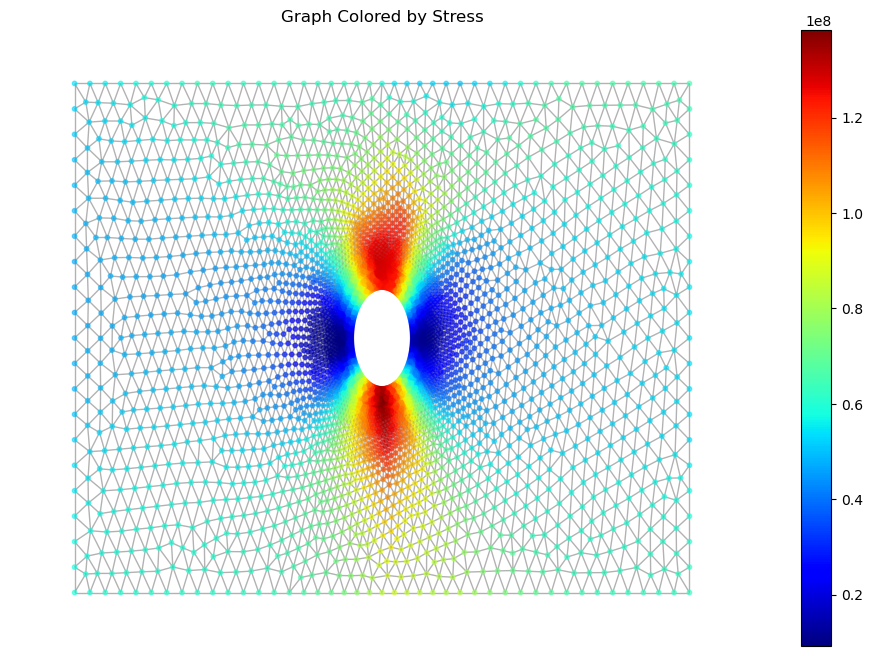

In [46]:
value = sxx

fig, ax = plt.subplots(figsize=(12, 8))

# Draw the graph on the given axis
nx.draw(G, pos, node_size=10, edge_color="gray", alpha=0.6,
        node_color=value, cmap="jet", vmin=value.min(), vmax=value.max(),
        ax=ax)

# Create a mappable and assign the stress values to it for the colorbar
mappable = plt.cm.ScalarMappable(cmap="jet")
mappable.set_array(value)

# Add the colorbar to the figure, using the axis
fig.colorbar(mappable, ax=ax)

ax.set_title("Graph Colored by Stress")
plt.show()